# <b><center>DarkVec: Automatic Analysis of Darknet Trafficwith Word Embeddings</center></b>

___
# <b>Table of Content</b> <a name="toc"></a>
* [<b>Semi-supervised Approach: Grid Search</b>](#gs)  
  * [Training Window Size](#gstrainwindow)  
  * [$k$ of k-Nearest-Neighbors Classifier](#gsk)  
  * [DarkVec Parameters Tuning](#gsdarkvec)  
    * [Auto-defined Languages](#auto)
    * [Per-service Languages](#perservice)
  * [7-NN classifier report](#7nnreport)  

In [1]:
from config import *
from src.callbacks import *
from src.utils import *
import pandas as pd
import numpy as np
import warnings
import json
from glob import glob

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import classification_report as report
from sklearn.metrics import accuracy_score as accuracy
from src.knngraph import *

from pandas.core.common import SettingWithCopyWarning
from pandas.errors import DtypeWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=SettingWithCopyWarning)
warnings.filterwarnings("ignore", category=DtypeWarning)

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import fastplot
from cycler import cycler

cc = (cycler('color',['k', 'r', 'b', 'g', 'y', 'm', 'c'])+
      cycler('linestyle',['-', '--', '-.', ':', '-', '--', '-.']))

___
# <b>Grid Search</b> <a name="gs"></a>
[Back to Index](#toc)

In [91]:
with open(f'{DATASETS}/ips.json', 'r') as file:
    filters = json.loads(file.read())

In [92]:
last_day = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
last_day = last_day[last_day.ip.isin(filters['d1_f30'])]
last_day.head()

,ts,ip,port,proto,pp,class
0,2021-03-31 08:29:08.449076,192.3.136.75,1970,TCP,1970/TCP,unknown
1,2021-03-31 08:29:08.449088,192.3.136.75,1970,TCP,1970/TCP,unknown
2,2021-03-31 08:29:08.451478,192.3.136.75,1970,TCP,1970/TCP,unknown
3,2021-03-31 08:29:08.451491,192.3.136.75,1970,TCP,1970/TCP,unknown
4,2021-03-31 08:29:08.459322,172.245.10.231,3956,TCP,3956/TCP,unknown


### <b>Training Window Size</b> <a name="gstrainwindow"></a>  
[Back to Index](#toc)

In [93]:
def extract_window_size_df(files, tr_days):
    f_list = []
    _files = []
    s_ips = []
    for i in tr_days[:-1]:
        f_list = []
        _files = []
        for x in files[-i:]: _files = _files + glob(x[7:])
        f_list.append(_files)
        for batch in f_list:
            df = pd.concat([pd.read_csv(_file, sep=' ') for _file in batch])\
                   .value_counts('src_ip')
            df = df[(df>=10) & (df.index.isin(known_ips))]
            coverage = len(df.index)*100/len(known_ips)
            s_ips.append(coverage)
    gs_train_window = [(tr_days[i], s_ips[i]) for i in range(len(tr_days)-1)]
    gs_train_window.append((tr_days[-1], 100.0))
    gs_train_window = pd.DataFrame(gs_train_window, columns=['training_days', 'ip_set'])
    
    return gs_train_window

In [95]:
files = DEBUG.split(',')
tr_days = [1, 2, 3, 4, 5, 10, 20, 30]
known_ips = set(last_day[last_day['class']!='unknown'].ip.unique())

#gs_train_window = extract_window_size_df(files, tr_days)
#gs_train_window.to_csv(f'{GRIDSEARCH}/training_window.csv', index=False)

gs_train_window = pd.read_csv(f'{GRIDSEARCH}/training_window.csv')
gs_train_window

,training_days,ip_set
0,1,32.582749
1,2,57.585825
2,3,69.595177
3,4,76.596530
4,5,81.826012
5,10,90.599237
6,20,97.194537
7,30,100.000000


<Figure size 640x480 with 0 Axes>

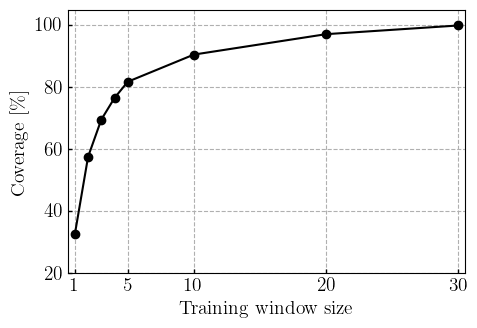

In [96]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig5(plt, gs_train_window),
                     style='latex', figsize=(5, 3.5), fontsize=14)
plot.show()

### <b> $k$ of k-Nearest-Neighbors Classifier</b> <a name="gsk"></a>  
[Back to Index](#toc)

In [97]:
def run_gs_knn_k(X, y, X_test, y_test):
    LIMIT = X_test.shape[0]
    accs = []
    ks = []
    cols = [str(i) for i in range(LIMIT)]
    for k_ in np.arange(2, 42):
        preds = []
        knn = KNN(n_neighbors=k_, metric='cosine', n_jobs=-1)
        knn.fit(X, y)
        pred_idx = knn.kneighbors(X_test[:LIMIT])[1][:, 1:]
        pred_lab = y[pred_idx]
        preds1 = [get_freqs(i) for i in pred_lab]
        accs.append(round(accuracy(y_test[:LIMIT], preds1), 2))
        ks.append(k_-1)
    
    _x_ = [ks[i] for i in range(len(ks)) if i%2 == 0]
    _y_ = [accs[i] for i in range(len(ks)) if i%2 == 0]
    
    return _x_, _y_

In [98]:
def extract_accuracy_res(ls, cs, vs):
    res = {}
    for i in range(3):
        # Load model
        mname = f'{ls[i]}_c{cs[i]}_v{vs[i]}_iter20'
        model = load_model(mname)
        # Retrieve embeddings
        dataset = last_day[['ip', 'class']].drop_duplicates()
        embeddings = get_scaled_embeddings(dataset, model, mname, True)
        # Run the kNN classifier
        X, y, X_test, y_test = split_train_test(embeddings, with_unknown=False)
        _x, _y = run_gs_knn_k(X, y, X_test, y_test)
        # Update outputs
        res[ls[i]] = {'x':_x, 'y':_y}
        
    knn_accs = pd.concat([pd.DataFrame(res[ls[i]])\
                 .rename(columns={'x':f'{ls[i]}_x', 
                                  'y':f'{ls[i]}_y'}) for i in range(3)],
                         axis=1)
    return knn_accs

In [99]:
cs = [75, 50, 25]
vs = [50, 50, 50]
ls = ['single', 'auto', 'service']

#knn_accs = extract_accuracy_res(ls, cs, vs)
#knn_accs.to_csv(f'{GRIDSEARCH}/knn_k.csv', index=False)

knn_accs = pd.read_csv(f'{GRIDSEARCH}/knn_k.csv')
knn_accs.head()

,single_x,single_y,auto_x,auto_y,service_x,service_y
0,1,0.37,1,0.86,1,0.84
1,3,0.67,3,0.94,3,0.93
2,5,0.79,5,0.96,5,0.95
3,7,0.84,7,0.96,7,0.96
4,9,0.86,9,0.96,9,0.96


<Figure size 640x480 with 0 Axes>

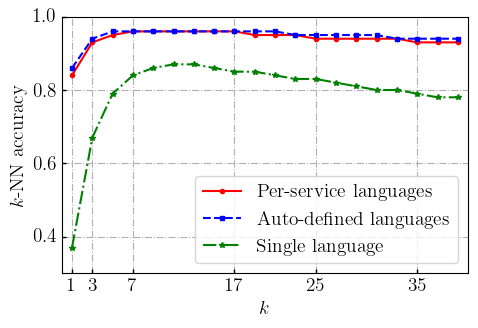

In [100]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig6(plt, knn_accs),
                     style='latex', figsize=(5, 3.5), fontsize=14)
plot.show()

### <b>DarkVec Parameters Tuning</b> <a name="gsdarkvec"></a>  
[Back to Index](#toc)

In [101]:
def grid_search_step(language, c, v):
    mname = f'{language}_c{c}_v{v}_iter20'
    model = load_model(mname)
    # Retrieve embeddings
    dataset = last_day[['ip', 'class']].drop_duplicates()
    embeddings = get_scaled_embeddings(dataset, model, mname, True)
    # Run the kNN classifier
    X, y, X_test, y_test = split_train_test(embeddings, with_unknown=False)
    y_true = y_test
    y_pred = fit_predict(X, y, X_test, y_test)
    # Get accuracy
    acc = report(y_true, y_pred, output_dict=True)['weighted avg']['recall']
    
    return acc

In [102]:
Vs = [50, 100, 150, 200]
Cs = [5, 25, 50, 75]

In [103]:
#parameter_tuning = pd.concat(dfs, axis=1)
#parameter_tuning.to_csv(f'{GRIDSEARCH}parameter_tuning.csv', index=False)

parameter_tuning = pd.read_csv(f'{GRIDSEARCH}/parameter_tuning.csv')
heatmaps = [parameter_tuning.pivot_table(
    index=f'{m}_v', columns=f'{m}_c', values=f'{m}_acc') for m in ['service', 'auto']]

parameter_tuning.head()

,service_c,service_v,service_acc,auto_c,auto_v,auto_acc
0,5,50,0.952996,5,50,0.948074
1,25,50,0.956811,25,50,0.964193
2,50,50,0.954104,50,50,0.963701
3,75,50,0.951643,75,50,0.961363
4,5,100,0.950166,5,100,0.938108


In [104]:
runtime = pd.read_csv(f'{GRIDSEARCH}/training_runtime.csv')
heatmaps_time = [runtime.pivot_table(
    index=f'{m}_v', columns=f'{m}_c', values=f'{m}_times') for m in ['service', 'auto']]

runtime.head()

,service_c,service_v,service_times,auto_c,auto_v,auto_times
0,50,100,2.526389,5,200,0.276389
1,75,100,3.716111,25,200,1.081944
2,5,50,0.372500,50,200,2.051667
3,25,50,1.153333,75,200,2.919444
4,50,50,2.165000,5,50,0.318056


### <b>Auto-defined Languages</b> <a name="auto"></a>  
[Back to Index](#toc)

<Figure size 640x480 with 0 Axes>

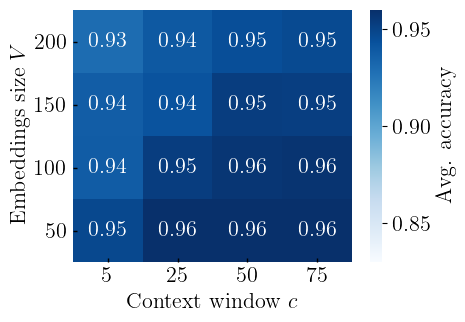

In [105]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig7a1(plt, heatmaps, Vs, Cs),
                     style='latex', figsize=(5, 3.5), fontsize=16)
plot.show()

<Figure size 640x480 with 0 Axes>

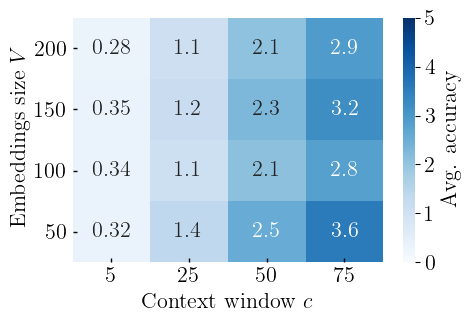

In [106]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig7a2(plt, heatmaps_time, Vs, Cs),
                     style='latex', figsize=(5, 3.5), fontsize=16)
plot.show()

### <b>Per-service Languages</b> <a name="perservice"></a> 
[Back to Index](#toc)

<Figure size 640x480 with 0 Axes>

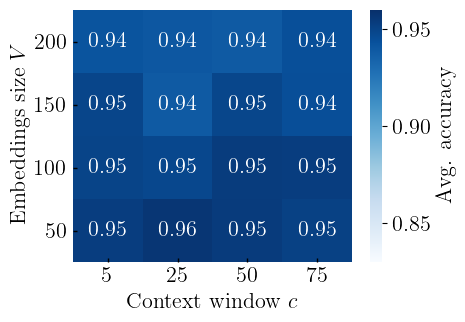

In [107]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig7b1(plt, heatmaps, Vs, Cs),
                     style='latex', figsize=(5, 3.5), fontsize=16)
plot.show()

<Figure size 640x480 with 0 Axes>

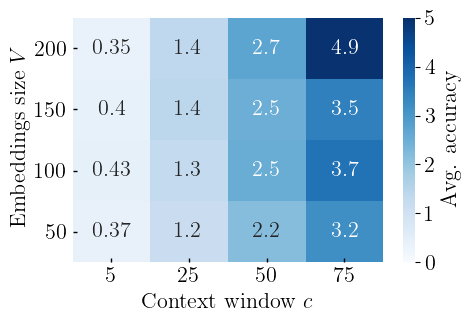

In [108]:
%matplotlib inline
plot = fastplot.plot(None,  None, mode = 'callback', callback = lambda plt: fig7b2(plt, heatmaps_time, Vs, Cs),
                     style='latex', figsize=(5, 3.5), fontsize=16)
plot.show()

### <b>State of Art Comparison</b> <a name="7nnreport"></a>  
[Back to Index](#toc)

#### <b>Darkvec 5 Days</b> <a name="7nnreport"></a>  

In [4]:
last5 = pd.read_csv(f'{DATASETS}/darknet_d1_f5.csv.gz')
mname = f'fivedays_c25_v50_iter20'
model = load_model(mname)
# Retrieve embeddings
dataset = last5[['ip', 'class']].drop_duplicates()
embeddings = get_scaled_embeddings(dataset, model, mname, True)
# Run the kNN classifier
X, y, X_test, y_test = split_train_test(embeddings, with_unknown=False)
y_true = y_test
y_pred = fit_predict(X, y, X_test, y_test)

print(report(y_true, y_pred))

                 precision    recall  f1-score   support

     binaryedge       0.92      0.94      0.93        83
         censys       0.77      0.92      0.84       336
    engin-umich       0.91      1.00      0.95        10
internet-census       0.85      0.79      0.82       103
           ipip       0.29      0.76      0.42        49
          mirai       0.99      0.96      0.98      5892
           n.a.       0.00      0.00      0.00         0
      sharashka       0.67      0.04      0.08        50
         shodan       0.67      0.09      0.15        23
     stretchoid       0.74      0.31      0.44       104
        unknown       0.00      0.00      0.00         0

       accuracy                           0.93      6650
      macro avg       0.62      0.53      0.51      6650
   weighted avg       0.97      0.93      0.94      6650



#### <b>IP2VEC 5 Days</b> <a name="7nnreport"></a>  

In [5]:
embeddings_ip2vec = pd.read_csv(f'{DATASETS}/embeddings_ip2vec.csv.gz')\
                      .set_index('ip')

# Run the kNN classifier
X, y, X_test, y_test = split_train_test(embeddings_ip2vec, with_unknown=False)
y_true = y_test
y_pred = fit_predict(X, y, X_test, y_test)

print(report(y_true, y_pred))

                 precision    recall  f1-score   support

     binaryedge       0.01      0.01      0.01        83
         censys       0.06      0.09      0.07       336
    engin-umich       0.06      0.10      0.07        10
internet-census       0.01      0.01      0.01       103
           ipip       0.01      0.02      0.02        49
          mirai       0.88      0.74      0.81      5892
           n.a.       0.00      0.00      0.00         0
      sharashka       0.00      0.00      0.00        50
         shodan       0.00      0.00      0.00        23
     stretchoid       0.00      0.00      0.00       104
        unknown       0.00      0.00      0.00         0

       accuracy                           0.67      6650
      macro avg       0.09      0.09      0.09      6650
   weighted avg       0.79      0.67      0.72      6650



### <b>7-NN classifier report</b> <a name="7nnreport"></a>  
[Back to Index](#toc)

In [4]:
last_day = pd.read_csv(f'{DATASETS}/darknet_d1.csv.gz')
last_day.head()

,ts,ip,port,proto,pp,class
0,2021-03-31 08:29:08.449076,192.3.136.75,1970,TCP,1970/TCP,unknown
1,2021-03-31 08:29:08.449088,192.3.136.75,1970,TCP,1970/TCP,unknown
2,2021-03-31 08:29:08.451478,192.3.136.75,1970,TCP,1970/TCP,unknown
3,2021-03-31 08:29:08.451491,192.3.136.75,1970,TCP,1970/TCP,unknown
4,2021-03-31 08:29:08.459322,172.245.10.231,3956,TCP,3956/TCP,unknown


In [5]:
mname = f'service_c25_v50_iter20'
model = load_model(mname)
# Retrieve embeddings
dataset = last_day[['ip', 'class']].drop_duplicates()
embeddings = get_scaled_embeddings(dataset, model, mname, True)
# Run the kNN classifier
X, y, X_test, y_test = split_train_test(embeddings, with_unknown=False)
y_true = y_test
y_pred = fit_predict(X, y, X_test, y_test)

print(report(y_true, y_pred))

                 precision    recall  f1-score   support

     binaryedge       0.94      1.00      0.97       101
         censys       0.91      0.94      0.93       336
    engin-umich       1.00      1.00      1.00        10
internet-census       0.94      1.00      0.97       103
           ipip       0.34      0.84      0.49        49
          mirai       1.00      0.97      0.98      7351
           n.a.       0.00      0.00      0.00         0
      sharashka       0.96      1.00      0.98        50
         shodan       0.93      0.61      0.74        23
     stretchoid       1.00      0.35      0.51       104
        unknown       0.00      0.00      0.00         0

       accuracy                           0.96      8127
      macro avg       0.73      0.70      0.69      8127
   weighted avg       0.99      0.96      0.97      8127



In [6]:
mname = f'auto_c50_v50_iter20'
model = load_model(mname)
# Retrieve embeddings
dataset = last_day[['ip', 'class']].drop_duplicates()
embeddings = get_scaled_embeddings(dataset, model, mname, True)
# Run the kNN classifier
X, y, X_test, y_test = split_train_test(embeddings, with_unknown=False)
y_true = y_test
y_pred = fit_predict(X, y, X_test, y_test)

print(report(y_true, y_pred))

                 precision    recall  f1-score   support

     binaryedge       0.98      0.87      0.92       101
         censys       0.96      1.00      0.98       336
    engin-umich       0.62      1.00      0.77        10
internet-census       0.79      0.86      0.83       103
           ipip       0.51      0.86      0.64        49
          mirai       1.00      0.98      0.99      7351
           n.a.       0.00      0.00      0.00         0
      sharashka       0.92      0.72      0.81        50
         shodan       0.94      0.70      0.80        23
     stretchoid       0.94      0.30      0.45       104
        unknown       0.00      0.00      0.00         0

       accuracy                           0.96      8127
      macro avg       0.70      0.66      0.65      8127
   weighted avg       0.99      0.96      0.97      8127



In [7]:
mname = f'single_c75_v50_iter20'
model = load_model(mname)
# Retrieve embeddings
dataset = last_day[['ip', 'class']].drop_duplicates()
embeddings = get_scaled_embeddings(dataset, model, mname, True)
# Run the kNN classifier
X, y, X_test, y_test = split_train_test(embeddings, with_unknown=False)
y_true = y_test
y_pred = fit_predict(X, y, X_test, y_test)

print(report(y_true, y_pred))

                 precision    recall  f1-score   support

     binaryedge       0.44      0.74      0.56       101
         censys       0.63      0.91      0.75       336
    engin-umich       0.67      1.00      0.80        10
internet-census       0.41      0.50      0.45       103
           ipip       0.42      0.92      0.58        49
          mirai       0.98      0.86      0.92      7351
           n.a.       0.00      0.00      0.00         0
      sharashka       0.12      0.02      0.03        50
         shodan       0.00      0.00      0.00        23
     stretchoid       0.03      0.01      0.01       104
        unknown       0.00      0.00      0.00         0

       accuracy                           0.84      8127
      macro avg       0.34      0.45      0.37      8127
   weighted avg       0.93      0.84      0.88      8127



In [8]:
# Choose the best

In [9]:
mname = f'service_c25_v50_iter20'
model = load_model(mname)
# Retrieve embeddings
dataset = last_day[['ip', 'class']].drop_duplicates()
embeddings = get_scaled_embeddings(dataset, model, mname, True)
embeddings.to_csv(f'{DATASETS}/embeddings_d1_f30.csv.gz')

In [10]:
embeddings.head()

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,class
ip,,,,,,,,,,,,,,,,,,,,,
192.3.136.75,-0.880609,0.939509,-0.981673,0.632472,-0.137714,-0.623512,-0.312578,0.353500,-0.481570,-0.092065,...,-0.083845,0.034996,1.871216,-1.650959,-0.546646,-2.534351,0.454603,0.401673,0.011954,unknown
172.245.10.231,-0.821886,0.938257,-0.939138,0.768093,-0.368143,-0.342307,0.361761,-0.020825,-0.124277,-0.606136,...,-0.158201,-0.086896,1.609598,-1.911658,-0.237953,-2.353073,0.416320,0.604326,0.213149,unknown
45.155.205.93,-0.853992,0.928514,-0.472147,0.761264,-0.075501,-0.727555,0.194575,0.136880,-0.299064,-0.551627,...,-0.455980,0.128353,1.622241,-2.089224,-0.368021,-2.283580,0.647499,0.296732,-0.031751,unknown
23.129.64.232,-1.217581,-0.378261,-0.192762,1.568114,-0.556128,-0.259799,0.965861,-0.516977,0.512646,-1.537555,...,-0.321514,0.101018,1.000412,-1.787732,-0.017220,0.311011,-1.012398,0.922475,-0.332703,unknown
192.241.222.5,-0.891606,-0.990258,0.346513,2.213809,0.213245,1.461398,-2.134602,1.168318,3.543771,-0.376963,...,-0.114518,2.805775,-4.283203,1.905293,-4.161075,1.423379,-1.779000,0.846066,0.539168,stretchoid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178.72.77.251,1.477921,-1.213938,-0.464699,-0.236900,-0.249695,0.249554,1.388844,-0.336507,0.476616,-0.974906,...,0.455370,0.825353,1.019679,0.149285,1.490883,0.043770,0.295792,-0.822799,-0.550597,mirai
42.224.6.216,0.933884,-1.121586,-0.154385,-0.570395,-0.320463,0.614718,0.088959,-1.004621,-0.008281,-0.480604,...,-0.000809,-0.008607,0.337016,1.044117,1.182827,-1.294980,-1.286891,-0.911279,1.101958,mirai
185.103.46.2,-2.137642,1.995658,0.582975,1.948516,-0.520679,-0.087886,1.204677,0.302347,0.258693,0.461983,...,-0.164654,0.382157,-1.308905,-0.538666,-0.124497,-0.948841,-0.640393,1.175979,-0.953269,unknown
